In [1]:
import os
import re

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics as skmetrics
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider


sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 

os.makedirs('out/figs', exist_ok=True)

print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))


# def show_pal0(palette):
#     sns.palplot(sns.color_palette(palette, 24))
#     print(palette)
# interact(show_pal0, palette='deep muted pastel bright dark colorblind'.split());

デフォルトのフォント: ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']


## Table2

Compare metrics between conditions

In [2]:
from scipy import stats
from functools import lru_cache

cache = {}
def load_df(p):
    if p in cache:
        print
        return cache[p]
    df = pd.read_excel(p, sheet_name='report', index_col=0)
    # cache[p] = df
    return df

metrics = {
    'Accuracy': lambda df: df[df.index == 'accuracy'].iloc[0, 0],
    'Accuracy(Patch)': lambda df: df[df.index == 'patch acc'].iloc[0, 0],
    'F1 score': lambda df: df[df.index == 'macro avg'].iloc[0]['f1-score'],
    'Precision': lambda df: df[df.index == 'macro avg'].iloc[0]['precision'],
    'Recall': lambda df: df[df.index == 'macro avg'].iloc[0]['recall'],
    # 'AUROC ': lambda df: df[df.index == 'auc'].iloc[0, 0],
}

def remove_suffix(text, suffix):
    if text.endswith(suffix):
        return text[:-len(suffix)]
    return text

def get_metrics(cond, label=True):
    global cache
    cache = {}
    mm = {}
    for k, fn in metrics.items():
        m = []
        for fold in range(5):
            p = f'out/compare/LMGAOB/fold5_{fold}/{cond}/test/report.xlsx'
            df = load_df(p)
            try:
                value = fn(df)
            except Exception as e:
                print('Error in', p)
                print(df)
                raise e
            m.append(value)
        mm[k] = m
    return mm


def summary_cond(cond, label=None):
    if label is None:
        label = cond
    m = get_metrics(cond)
    df = pd.DataFrame(m)
    # df = pd.concat([pd.DataFrame([{'cond': cond}]*5), df])
    cond_org = remove_suffix(cond, '_1e-5')
    limit = int(re.match(r'^.*_(\d+)$', cond_org)[1])
    df = pd.DataFrame([{'cond': cond, 'limit': limit, 'label': label}]*5).join(df)
    df = df.reset_index().rename(columns={'index': 'fold'})
    return df



conds_base = [
    'unfrozen_uni_{}',
    'frozen_uni_{}',
    'frozen_gigapath_{}',
    'unfrozen_ctranspath_{}',    
    'frozen_ctranspath_{}',
    'unfrozen_baseline-vit_{}',
    'unfrozen_baseline-cnn_{}',
]
labels = [
    'UNI(Enc+FC)',
    'UNI(FC)',
    'Prov-GigaPath(FC)',    
    'CTransPath(Enc+FC)',
    'CTransPath(FC)',
    r'VIT-L$\mathrm{_{IN}}$(Enc+FC)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(Enc+FC)',
]

with pd.ExcelWriter('out/figs/results_cv.xlsx') as w:
    for limit in [10, 25, 100, 500]:
        dfs = [summary_cond(c.format(limit), l) for c, l in zip(conds_base, labels)]
        df = pd.concat(dfs).reset_index(drop=True)
        df.to_excel(w, sheet_name=f'{limit}')

print('wrote out/figs/results_cv.xlsx')

wrote out/figs/results_cv.xlsx


In [3]:
with pd.ExcelWriter('out/figs/table2_mean.xlsx') as w:
    for limit in [10, 25, 100, 500]:
        df = pd.read_excel('out/figs/results_cv.xlsx', sheet_name=f'{limit}', index_col=0)
        data = []
        labels = df['label'].unique()
        for l in labels:
            vvv = df[df['label'] == l]
            ss = {}
            for m in metrics:
                vv = vvv[m].values
                s = '{:.3f} ± {:.3f}'.format(np.mean(vv), stats.sem(vv))
                ss[m] = s
            data.append(ss)
        df2 = pd.DataFrame(data, index=labels)
        df2.to_excel(w, sheet_name=f'{limit}')
        w.sheets[f'{limit}'].set_column('A:A', 20)
        w.sheets[f'{limit}'].set_column('B:Z', 12)

print('wrote out/figs/table2_mean.xlsx')
df2

wrote out/figs/table2_mean.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
UNI(Enc+FC),0.942 ± 0.012,0.912 ± 0.005,0.861 ± 0.031,0.887 ± 0.037,0.866 ± 0.026
UNI(FC),0.949 ± 0.015,0.904 ± 0.009,0.885 ± 0.034,0.917 ± 0.030,0.883 ± 0.033
Prov-GigaPath(FC),0.949 ± 0.014,0.908 ± 0.008,0.881 ± 0.035,0.912 ± 0.030,0.881 ± 0.036
CTransPath(Enc+FC),0.947 ± 0.015,0.892 ± 0.007,0.876 ± 0.034,0.909 ± 0.030,0.879 ± 0.033
CTransPath(FC),0.939 ± 0.006,0.865 ± 0.008,0.866 ± 0.018,0.887 ± 0.015,0.870 ± 0.023
VIT-L$\mathrm{_{IN}}$(Enc+FC),0.927 ± 0.010,0.876 ± 0.009,0.833 ± 0.031,0.864 ± 0.035,0.833 ± 0.030
ResNet-RS 50$\mathrm{_{IN}}$(Enc+FC),0.937 ± 0.013,0.880 ± 0.006,0.845 ± 0.039,0.858 ± 0.042,0.853 ± 0.037


## Paired t-test

### 100 patches/case

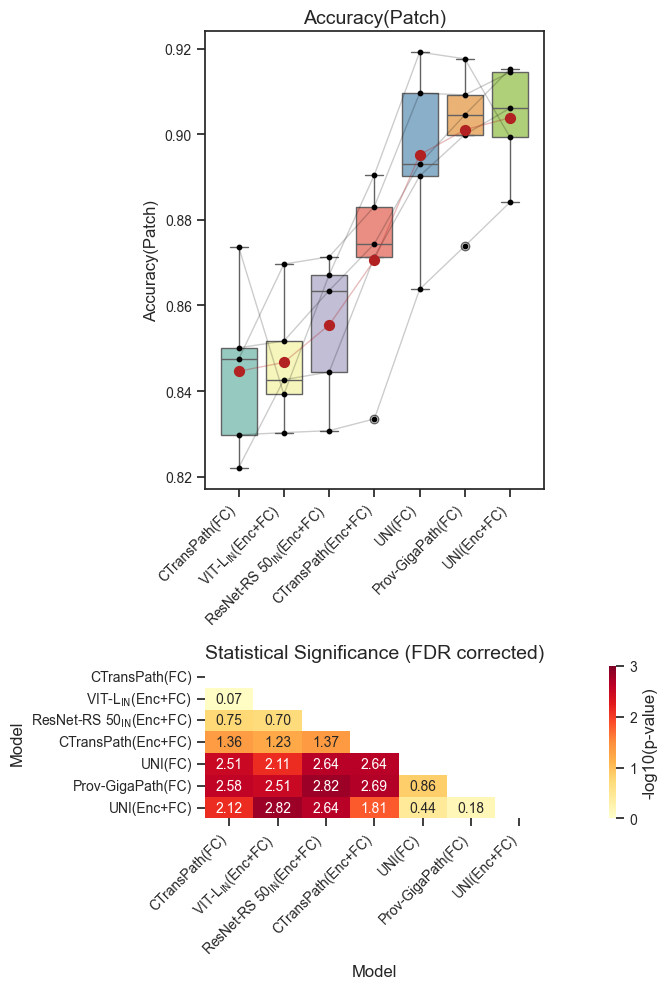

In [4]:
from statsmodels.stats.multitest import multipletests

def paired_box(df, target, title=None, verbose=False):
    n_folds, n_models = 5, len(df)//5

    df_mean = df.groupby('cond')[target].mean().sort_values(ascending=True)
    df[f'average_{target}'] = df['cond'].map(df_mean)
    df = df.sort_values([f'average_{target}', 'fold'], ascending=[True, True])
    labels = df['label'].unique()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10), gridspec_kw={'height_ratios': [3, 1]})
    plt.subplots_adjust(hspace=0.3)
    
    # ボックスプロットの作成
    sns.boxplot(x='label', hue='label', y=target, data=df, palette='Set3', legend=False, ax=ax1)

    
    # foldごとにつないでプロット
    for fold in range(n_folds):
        fold_data = df[df['fold'] == fold]
        ax1.plot(range(n_models), fold_data[target], 'k-', alpha=0.2, linewidth=1)

    for i, label in enumerate(labels):
        ax1.scatter([i] * n_folds, df[df['label'] == label][target], color='black', s=10, zorder=3)

    # 平均をプロット
    ax1.plot(range(n_models), df_mean, 'firebrick', linewidth=1, zorder=4, alpha=0.3)
    ax1.scatter(range(n_models), df_mean, color='firebrick', s=50, zorder=5, label='Mean')

    ax1.set_title(target)
    ax1.set_xticks(range(len(labels)))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.set_ylabel(target)

    p_values = []
    for i in range(n_models):
        for j in range(i+1, n_models):
            a = df[df['label']==labels[i]][target]
            b = df[df['label']==labels[j]][target]
            t_stat, p_value = stats.ttest_rel(a, b)
            p_values.append(p_value)
    
    # Benjamini-Hochberg法による多重検定の補正
    _, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    # p_corrected = p_values
       
    sig_matrix = np.zeros((n_models, n_models))
    k = 0
    for i in range(n_models):
        for j in range(i+1, n_models):
            sig_matrix[j, i] = -np.log10(p_corrected[k])  # 左下三角形に値を設定
            k += 1

        
    # マスクの作成（下三角形のみを表示）
    mask = np.triu(np.ones_like(sig_matrix, dtype=bool), k=0)
    
    # ヒートマップの作成
    heatmap = sns.heatmap(sig_matrix, mask=mask, annot=True, fmt='.2f', cmap='YlOrRd', 
                ax=ax2, cbar_kws={'label': '-log10(p-value)'}, vmin=0.0, vmax=3.0)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_yticklabels(labels, rotation=0)
    ax2.set_title('Statistical Significance (FDR corrected)')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Model')
    
    cbar_pos = heatmap.collections[0].colorbar.ax.get_position()
    plt.tight_layout()
    ax1_pos = ax1.get_position()
    ax2_pos = ax2.get_position()
    new_width = cbar_pos.x0 - ax2_pos.x0
    ax1.set_position([ax1_pos.x0, ax1_pos.y0, new_width, ax1_pos.height])
    ax2.set_position([ax2_pos.x0, ax2_pos.y0, new_width, ax2_pos.height])



df_100 = pd.read_excel('out/figs/results_cv.xlsx', sheet_name='100', index_col=0)
paired_box(df_100, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_100_pacc.png", format="png", dpi=300)
plt.show()

fig2: 異なるモデルのパッチレベル精度の比較と統計的有意差

(A) 7つの異なる深層学習モデルのパッチレベル精度をボックスプロットで示す。各ボックスは四分位範囲を、ひげは1.5倍の四分位範囲内のデータ範囲を示す。外れ値は個別の点として表示。黒い点は個々のフォールドのスコアを、赤い点は平均値を示す。モデルは平均精度の昇順に左から右へ配置。

(B) モデル間のパッチレベル精度の統計的有意差をヒートマップで示す。色の濃さと数値は-log10(補正済みp値)を表し、値が大きいほど強い有意差を示す。p値はペアワイズのt検定（両側）で算出し、Benjamini-Hochberg法で多重比較補正を適用。ヒートマップの各セルは、行のモデルと列のモデルの比較を表す。-log10(p値) > 1.30は5%水準で有意 (p < 0.05)、> 2は1%水準で有意 (p < 0.01)、> 3は0.1%水準で極めて有意 (p < 0.001) を示す。

UNIとGigaPathモデルがCTransPathを上回った(p<0.05)、およびBaselineモデルsを大きく上回った。CTransPathは

大きく3つのグループに分けることができ、下位はBaselineモデルであるVIT-L(Enc+FC)とResNet-RS 50(Enc+FC)およびCTransPath(FC)が入り、中位にCTransPath(Enc+FC)、上位にUNI(Enc+FC)とUNI(FC)とProv-GigaPath(FC)と分けることができる。

CTransPathはこれまでのINのpretrainedよりは良いベースラインとして位置していることがわかる。しかし最も注目に値するのは、UNI(FC)がCTransPath(Enc+FC)を上回り、new generationのfoundation modelsのfinetune(Enc+FC)条件と同等の精度を示したことである。

macroレベルのAccuracyとF1 scoreでは差は得られなかった。　

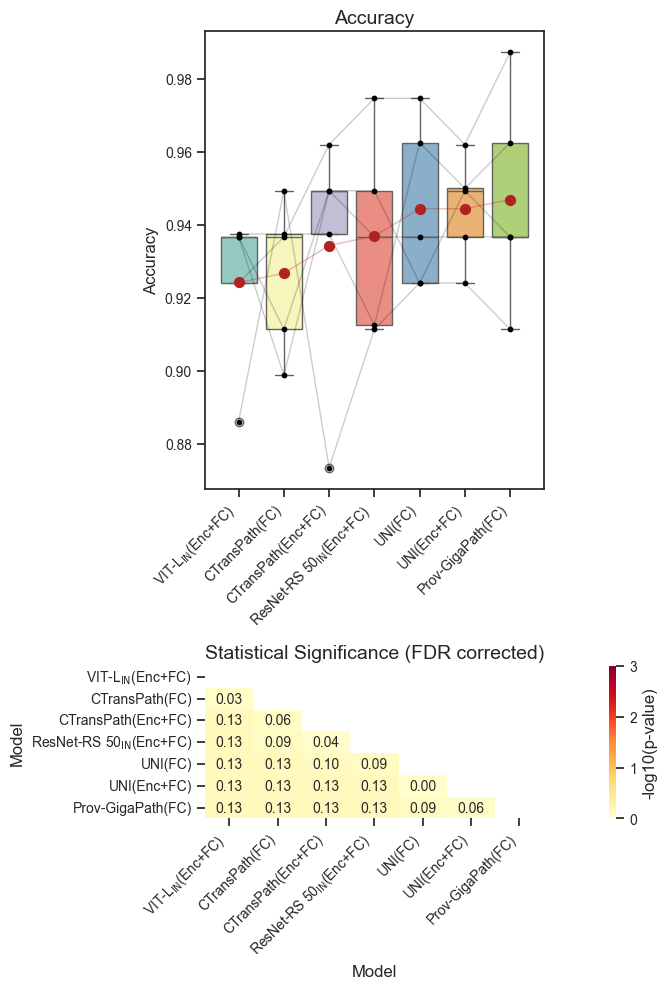

In [5]:
paired_box(df_100, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_100_acc.png", format="png", dpi=300)
plt.show()

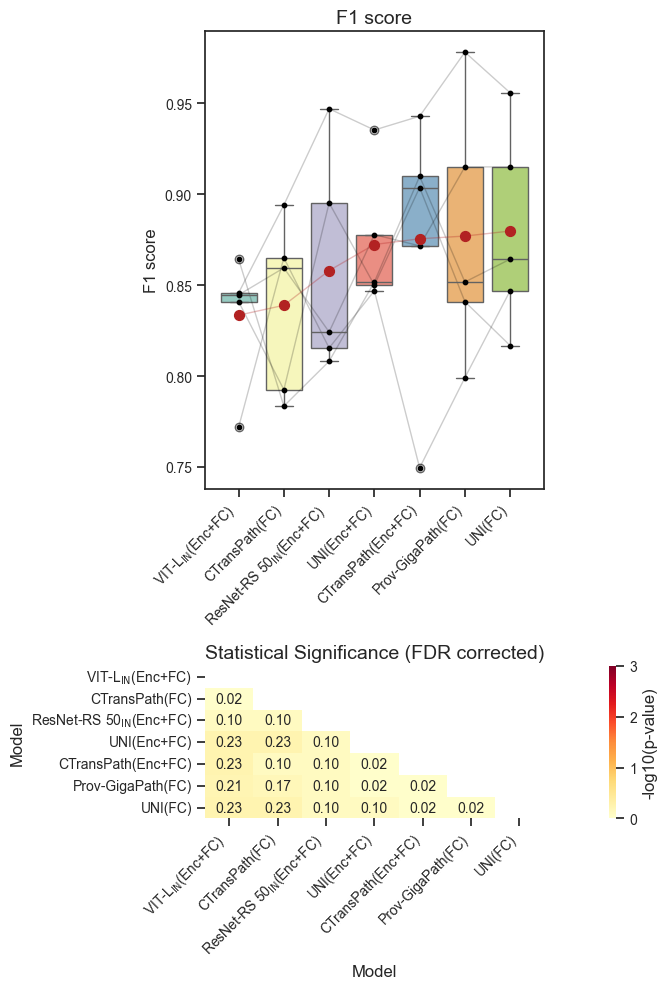

In [6]:
paired_box(df_100, 'F1 score', verbose=False)
plt.savefig("out/figs/fig3_100_f1.png", format="png", dpi=300)
plt.show()

In [7]:
# 500 patches/case

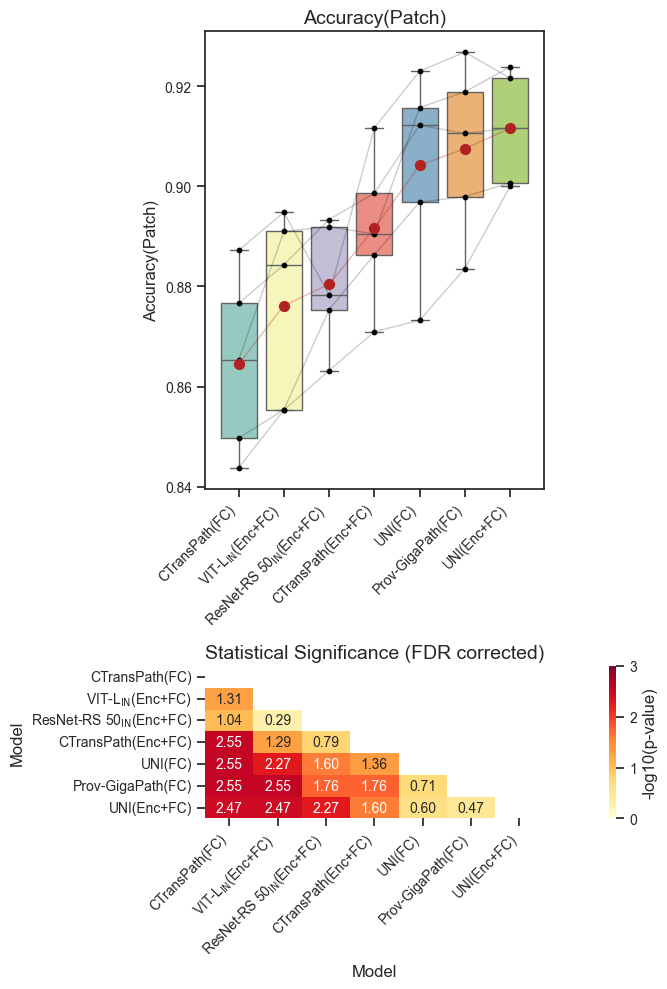

In [8]:
df_500 = pd.read_excel('out/figs/results_cv.xlsx', sheet_name='500', index_col=0)
paired_box(df_500, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_500_pacc.png", format="png", dpi=300)
plt.show()

# 25 patches/case

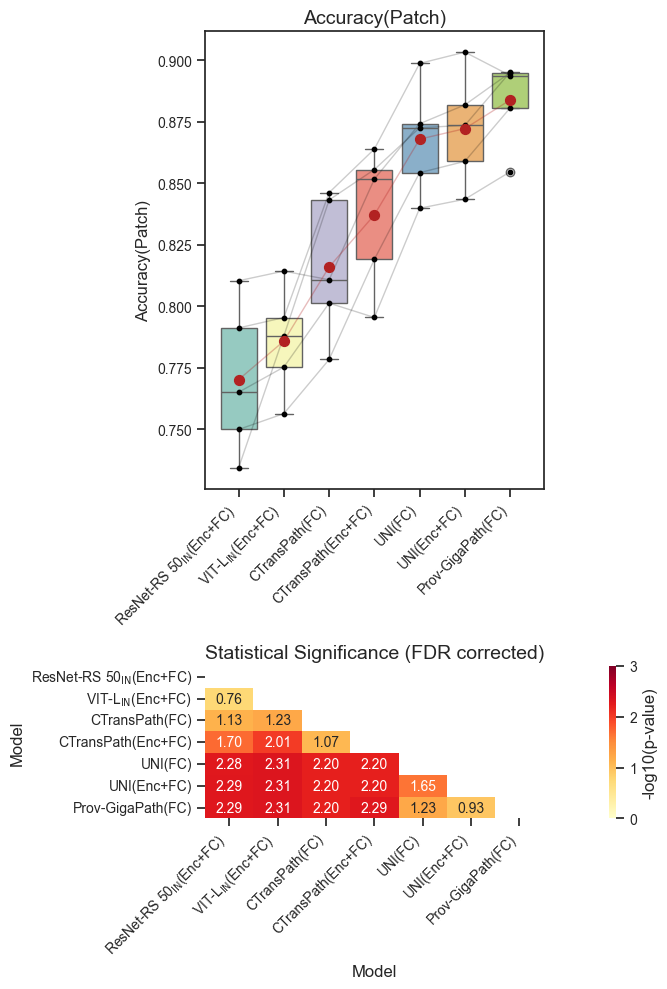

In [9]:
df_25 = pd.read_excel('out/figs/results_cv.xlsx', sheet_name='25', index_col=0)
paired_box(df_25, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_25_pacc.png", format="png", dpi=300)
plt.show()

# 10 patches/case

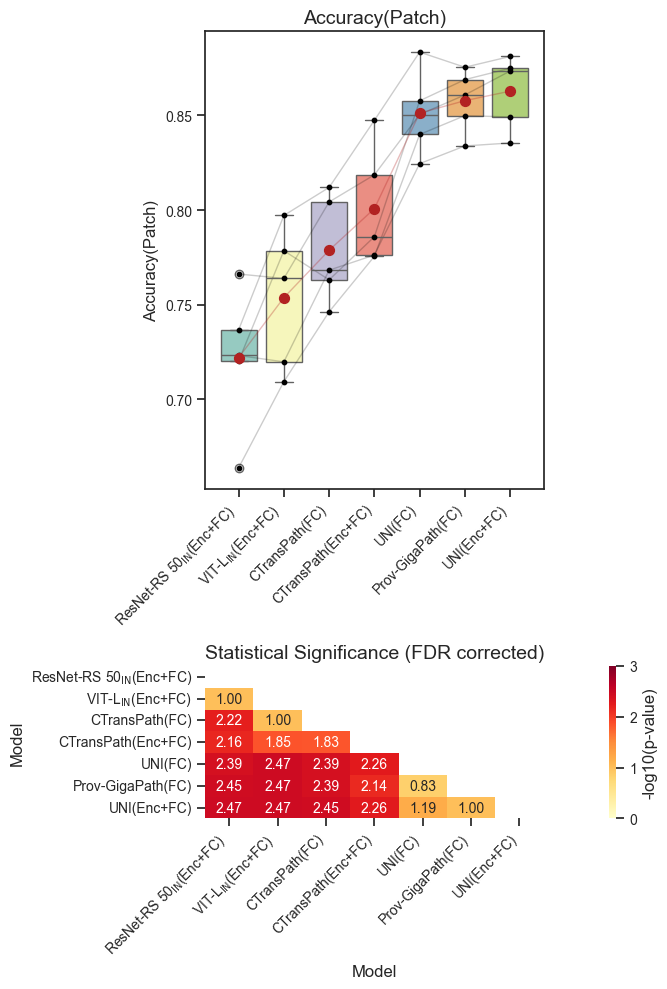

In [10]:
df_10 = pd.read_excel('out/figs/results_cv.xlsx', sheet_name='10', index_col=0)
paired_box(df_10, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_10_pacc.png", format="png", dpi=300)
plt.show()

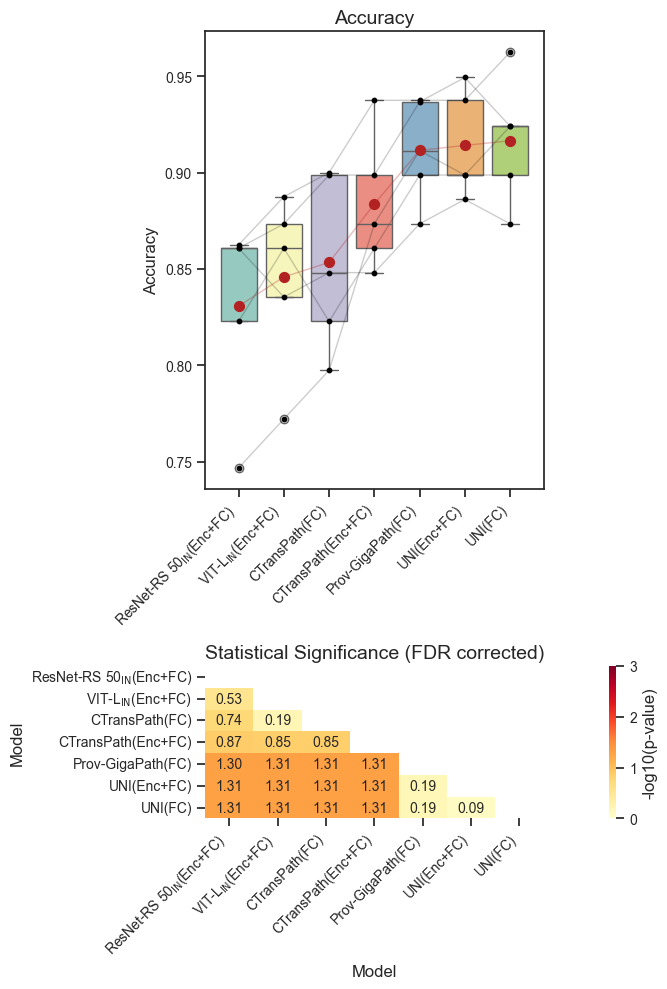

In [11]:
paired_box(df_10, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_10_acc.png", format="png", dpi=300)
plt.show()

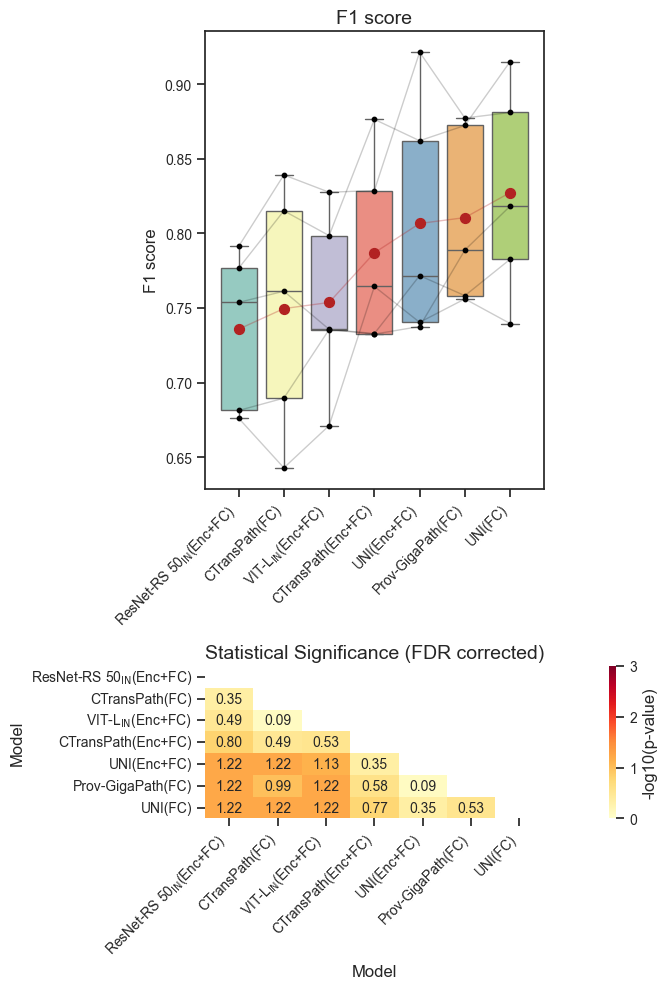

In [12]:
paired_box(df_10, 'F1 score', verbose=False)
plt.savefig("out/figs/fig3_10_f1.png", format="png", dpi=300)
plt.show()

In [13]:
p = 'out/compare/LMGAOB/fold5_0/frozen_uni_100/ebrains.xlsx'
df_patches = pd.read_excel(p, sheet_name='patches')
df_cases = pd.read_excel(p, sheet_name='cases')

y_true = df_cases['label']
y_pred = df_cases['pred']
report = skmetrics.classification_report(y_true, y_pred, output_dict=True, zero_division=0.0)
report = pd.DataFrame(report)
# report = skmetrics.classification_report(y_true, y_pred)
report['patch acc'] = df_patches['correct'].mean()
report = report.T



def get_metrics(cond, label=True):
    global cache
    cache = {}
    mm = {}
    for k, fn in metrics.items():
        m = []
        for fold in range(5):
            p = f'out/compare/LMGAOB/fold5_{fold}/{cond}/test/report.xlsx'
            df = load_df(p)
            try:
                value = fn(df)
            except Exception as e:
                print('Error in', p)
                print(df)
                raise e
            m.append(value)
        mm[k] = m
    return mm


def summary_cond(cond, label=None):
    if label is None:
        label = cond
    m = get_metrics(cond)
    df = pd.DataFrame(m)
    # df = pd.concat([pd.DataFrame([{'cond': cond}]*5), df])
    cond_org = remove_suffix(cond, '_1e-5')
    limit = int(re.match(r'^.*_(\d+)$', cond_org)[1])
    df = pd.DataFrame([{'cond': cond, 'limit': limit, 'label': label}]*5).join(df)
    df = df.reset_index().rename(columns={'index': 'fold'})
    return df

#### fig4

This fig shows the impact of patch number per case on model performace

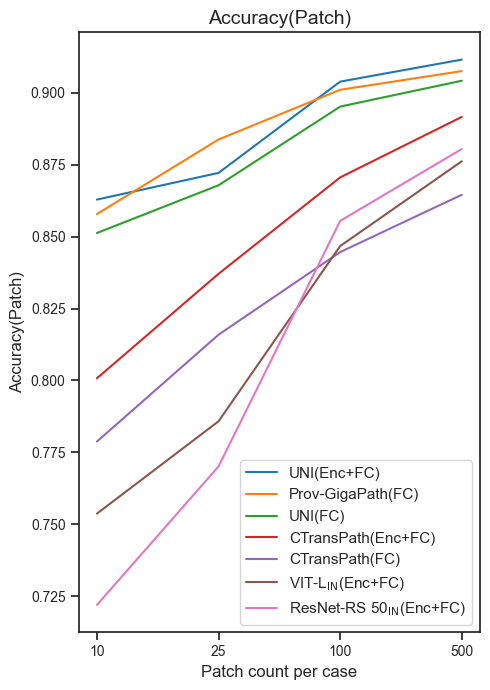

In [14]:
def draw_lines(target, labels=None):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    limits = [10, 25, 100, 500]
    alpha = 0.05
    
    values_by_limit = []

    for limit in limits:
        values = []
        df = pd.read_excel('out/figs/results_cv.xlsx', sheet_name=f'{limit}', index_col=0)

        if labels is None:
            if limit == limits[0]:
                # sort on 10 limit
                df_mean = df.groupby('label')[target].mean().sort_values(ascending=True)
                df[f'average_{target}'] = df['label'].map(df_mean)
                df = df.sort_values([f'average_{target}', 'fold'], ascending=[True, True])
                labels = df['label'].unique()[::-1]

        for label in labels:
            scores = df[df['label']==label][target]
            mean = np.mean(scores)
            diff = stats.sem(scores)
            # CI
            # diff = stats.t.interval(1 - alpha, df=len(scores)-1, loc=mean, scale=diff)[1] - mean
            values.append([mean, mean-diff, mean+diff])
        values_by_limit.append(values)    
    values_by_cond = np.array(values_by_limit).transpose(1, 0, 2)
    
    plt.figure(figsize=(5, 7))
    x = np.arange(1, 1+len(limits))
    
    for i in range(len(labels)):
        ci_l = values_by_cond[i, :, 1]
        ci_h = values_by_cond[i, :, 2]
        c = colors[i]
        plt.plot(x, values_by_cond[i, :, 0], color=c, label=labels[i])
        # plt.fill_between(x, ci_l, ci_h, color=c, alpha=0.1)
    
    plt.xticks(x, limits)
    plt.xlabel('Patch count per case')
    plt.ylabel(target)
    plt.legend(loc='lower right')
    plt.title(target)
    # plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return labels

labels = [
    'UNI(Enc+FC)',
    'Prov-GigaPath(FC)',
    'UNI(FC)',
    'CTransPath(Enc+FC)',
    'CTransPath(FC)',
    'VIT-L$\\mathrm{_{IN}}$(Enc+FC)',
    'ResNet-RS 50$\\mathrm{_{IN}}$(Enc+FC)',
]
draw_lines('Accuracy(Patch)', labels)
plt.savefig(f"out/figs/fig4_pacc.png", format="png", dpi=300)
plt.show()

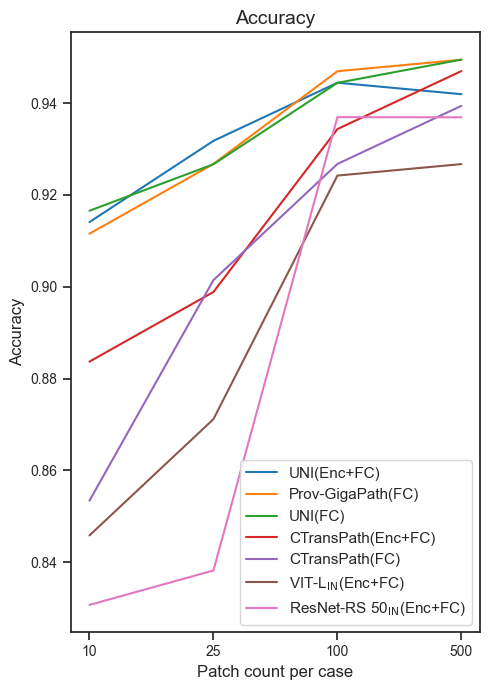

In [15]:
draw_lines('Accuracy', labels)
plt.savefig(f"out/figs/fig4_acc.png", format="png", dpi=300)
plt.show()

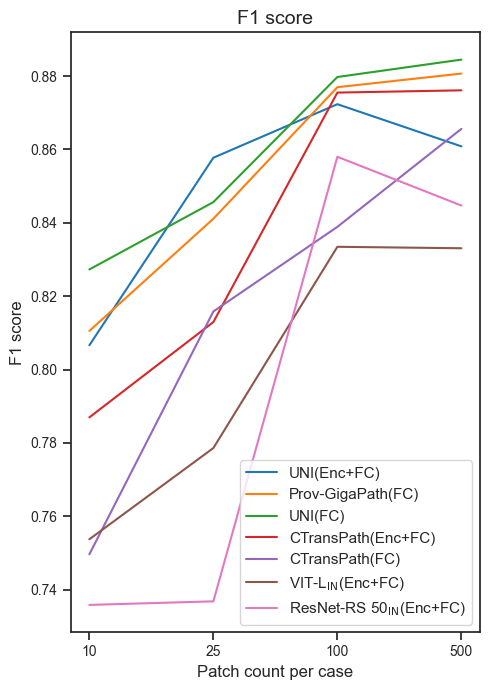

In [16]:
draw_lines('F1 score', labels)
plt.savefig(f"out/figs/fig4_f1.png", format="png", dpi=300)
plt.show()